# Hidden Shift Problem

이번 튜토리얼에서는 hidden shift problem에 대해서 배워보겠습니다. 이 튜토리얼에서는 bent function 상에서 정의된 hidden shift problem과 이 문제를 푸는 2가지의 양자 알고리즘을 다룹니다. 또한 이 알고리즘을 직접 Qiskit으로 구현하고 시뮬레이터 또는 실제 양자컴퓨터에서 실행해봅니다.

## 목차

1. [개요](#introduction)  
   1.1 [Bent Function 상에서 정의된 Hidden Shift Problem](#hidden-shift-problem-over-bent-functions)  
   1.2 [Fourier-transform을 이용한 알고리즘](#fourier-transform-accessible-algorithm)  
   1.3 [Fourier-transform을 이용하지 않는 알고리즘](#fourier-transform-free-algorithm)  
2. [예시](#example)  
3. [Qiskit 구현](#implementation)  
   3.1 [Fourier-transform을 이용한 알고리즘](#ftaa)  
   3.2 [Fourier-transform을 이용하지 않는 알고리즘](#ftfa)  
<!--    3.3 [Integer-Valued Algorithm](#iva)   -->
4. [문제](#problems)  
<!-- 6. [Cryptanalysis of Poly1305](#poly1305)   -->
5. [참고자료](#references)

## 1. 개요 <a id='introduction'> </a>

Hidden shift problem은 oracle이 주어지는 문제이며, Simon's problem이나 소인수분해 문제와도 연관이 있습니다. 특히, bent function 상에서 정의된 hidden shift problem은 양자컴퓨터로 풀 때 exponential quantum advantage가 있는 것으로 알려져 있습니다 [1, 2].

Bent function은 maximally non-linear한 Boolean 함수를 지칭하며, linear 함수나 affine 함수로 근사하기가 어렵기 때문에 암호학 분야에서 중요한 역할을 합니다 [3].

이러한 quantum advantage는 일반적 정수 함수 상에서 정의된 hidden shift problem에서도 일정 부분 작동하며, 이로 인해 Poly1305, CSIDH 등의 암호체계가 위협받을 수도 있습니다 [4]. 이러한 중요성 때문에 hidden shift problem을 푸는 알고리즘들은 양자컴퓨터의 성능을 벤치마킹 할 때에도 중요하게 고려되고 있습니다 [5, 6].

이번 튜토리얼에서는 exponential speedup이 있는 bent function 상의 hidden shift problem만을 다루도록 하겠습니다.

### 1.1 Bent Function 상에서 정의된 Hidden Shift Problem <a id='hidden-shift-problem-over-bent-functions'> </a>

$n$-비트 bent function $f, g: \mathbb{Z}^n_2 \rightarrow \mathbb{Z}_2$ 가 다음의 관계를 만족한다고 가정합니다: 어떤 "hidden shift" $s \in \mathbb{Z}^n_2$ 에 대하여 $f(x + s) = g(x)$.

$f, g$ 함수를 실행하는 oracle이 주어졌을 때 (또는 그것의 Fourier transform $\tilde{f}, \tilde{g}$도 실행할 수 있을 때), 어떻게 하면 최소한의 실행 횟수로 hidden shift $s$를 알아낼 수 있을까요?

### 1.2 Fourier-transform을 이용한 알고리즘 <a id='fourier-transform-accessible-algorithm'> </a>

먼저 oracle이 Fourier transform된 함수 $\tilde{f}$를 실행할 수 있는 경우를 살펴봅시다. 이 알고리즘은 참고자료 [1]에서 처음 발견되었습니다.

#### 1.2a 고전 알고리즘

단순하게 모든 입력값에 대한 결과값 $f(x)$, $g(x)$를 알아보는 경우 oracle에 엑세스하는 횟수는 $2 \cdot 2^n$번 입니다. 참고자료 [1]에서는 Fourier transform $\tilde{f}$를 실행할 수 있는 경우, 푸리에 해석을 적용하면 $\Theta(n)$ order의 실행 횟수 내로 hidden shift $s$를 알아낼 수 있다고 하였습니다.

#### 1.2b 양자 알고리즘

양자 알고리즘을 바로 살펴보기 전에, Boolean group $\mathbb{Z}^n_2$과 여기서의 Fourier transform에 대해 먼저 알아봅시다. Boolean group에서의 덧셈은 각 자릿수의 XOR 함수로 정의됩니다: $01 + 11 = (0+1, 1+1) = 10$. 이러한 Boolean group에서 실수로 가는 함수 $f : \mathbb{Z}^n_2 \rightarrow \mathbb{R}$의 Fourier transform $\tilde{f} : \mathbb{Z}^n_2 \rightarrow \mathbb{R}$는 다음과 같이 정의됩니다:

$$
\tilde{f}(x) = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{x \cdot y}f(y)
$$

여기서 흥미로운 점은 이러한 경우의 Fourier transform을 특별히 "Hadamard transform"이라고 부른다는 것인데, 일반적인 큐비트에서의 Hadamard gate가 다음과 같이 작동한다는 것과 비교해봅시다:

$$
H \left| x \right> = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{x \cdot y} \left| y \right>,
$$

이제 다시 양자 알고리즘을 살펴봅시다.

만약 oracle에서 함수의 Fourier transform을 실행할 수 있다면, 양자 알고리즘에서는 hidden shift $s$를 한 번에 찾아낼 수 있습니다.

![hsp_ftaa](images/hsp_ftaa.jpg)

주어진 함수 $f$에 대해, oracle $U_f$는 주어진 함수를 다음과 같이 암호화합니다.

$$
U_f \left| x \right> = (-1)^{f(x)} \left| x \right> \equiv F(x) \left| x \right>
$$

이 oracle은 입력 상태 $\left| x \right>$에 대응하는 함숫값에 따라 위상 반전을 가합니다. 이것을 간단하게 $(-1)^{f(x)} = F(x)$로 쓰면 Fourier 해석에 의해 다음의 사실 또한 활용할 수 있습니다: $\tilde{F}(x) = (-1)^{\tilde{f}(x)}$.

이제 그림에서 나타내는 알고리즘을 한 단계씩 따라가봅시다:

<ol>
   <li>
        $n$-큐빗 레지스터를 0으로 초기화합니다:  
$$
\left| \psi_1 \right> = \left| 0 \right> ^{\otimes n}
$$

   </li>
   
   <li>
        전체 큐빗에 Hadamard transform을 가합니다:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| x \right>
$$

   </li>

   <li>
        Oracle $U_{g}$를 실행합니다:  
$$
\begin{aligned}
    \left| \psi_3 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} G(x) \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x + s) \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Hadamard gate (Fourier transform) 를 다시 가합니다:  
$$
\begin{aligned}
    \left| \psi_4 \right>
        & = \frac{1}{2^n} \sum_{y} \left[ \sum_{x} (-1)^{x \cdot y} F(x + s) \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left[ \frac{1}{\sqrt{2^n}} \sum_{x} (-1)^{(x + s) \cdot y} F(x + s) \right] \left| y \right>
\end{aligned}
$$

한편 대괄호 안의 수식은 다름 아닌 $\tilde{F}(y)$입니다:  
$$
= \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \tilde{F}(y) \left| y \right>
$$

   </li>

   <li>
        Oracle $U_{\tilde{f}}$를 실행합니다:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \tilde{F}(y) \tilde{F}(y) \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left| y \right>
\end{aligned}
$$
        
   </li>

   <li>
        마지막으로 Hadamard transform (Fourier transform) 을 다시 가해 $\left| s \right>$를 얻습니다:  
$$
\left| \psi_6 \right> = \left| s \right>
$$
        
   </li>
</ol>

따라서, 주어진 hidden shift problem이 $U_g$ 한 번, $U_{\tilde{f}}$ 한 번의 실행만으로 풀리게 됩니다.

### 1.3 Fourier-transform을 이용하지 않는 알고리즘 <a id='fourier-transform-free-algorithm'> </a>

이번에는 oracle이 Fourier transform을 제공하지 않는 경우에 대해 생각해보겠습니다. 고전적인 방법에서 이 경우는 기하급수적으로 어려워지게 됩니다. 반면 양자 알고리즘은 이 문제를 여전히 선형 시간 안에 풀 수 있습니다. 이 알고리즘은 참고자료 [1]에서 처음 제시되었으며, 참고자료 [2]에서 추가로 개선되었습니다. 이 튜토리얼에서는 개선된 버전의 알고리즘을 소개하도록 하겠습니다.

#### 1.3a 고전 알고리즘

Fourier transform에 엑세스할 수 없는 경우에 대해, 참고자료 [2]에서 이 문제의 고전적 복잡도는 $\Omega \left( \sqrt{2^n} \right)$라는 것을 밝혀냈습니다. 즉, 이 문제를 풀기 위해 최소 $\sqrt{2^n}$ order의 oracle 실행이 필요합니다. 가장 단순한 brute-force approach에서 필요한 실행 횟수가 $2^n$ order였다는 것과 비교해볼 수 있습니다.

#### 1.3b The Quantum Solution

이 문제를 양자 알고리즘으로 푸는 경우 $O(n)$ order의 실행 횟수 내에 확률적으로 문제를 풀 수 있습니다.

![hsp_ftfa](images/hsp_ftfa.jpg)

주어진 함수 $f$에 대해 oracle $O$는 다음과 같이 $f$를 인코딩합니다:

$$
O_f \left| b \right> \left| x \right> = \left| b + f(x) \right> \left| x \right>
$$

$O$는 두 번째 레지스터를 입력으로 받아 첫 번째 레지스터에 함숫값을 출력합니다. 여기서 정의된 oracle $O$가 앞에서 정의된 $U$와 약간 다르다는 점에 주의해주세요.

이제 그림에 표시된 순서를 따라 알고리즘을 살펴봅시다:

<ol>
   <li>
        입출력 레지스터를 전부 초기화합니다:  
$$
\left| \psi_1 \right> = \left| 0 \right> \left| 0 \right>^{\otimes n}
$$
   </li>
   
   <li>
        입력 레지스터에 Hadamard gate를 가해 모든 상태를 중첩시킵니다:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| 0 \right> \left| x \right>
$$

   </li>

   <li>
        Oracle $O_f$를 실행합니다:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| f(x) \right> \left| x \right>
$$

   </li>

   <li>
        출력 레지스터에 Z gate를 (위상 반전) 가합니다:  
$$
\left| \psi_4 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) \right> \left| x \right>
$$

   </li>

   <li>
        Oracle $O_g$를 실행합니다:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) + g(x) \right> \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        입력 레지스터에 Hadamard transform (Fourier transform)을 가합니다:  
$$
\begin{aligned}
    \left| \psi_6 \right>
        & = \frac{1}{2^n} \sum_{x, y} (-1)^{x \cdot y} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{2^n} \sum_{x, y} \left[ \frac{(-1)^{x \cdot y} F(x) + (-1)^{x \cdot y} F(x + s)}{2} \left| 0 \right> + \frac{(-1)^{x \cdot y} F(x) - (-1)^{x \cdot y} F(x + s)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} \left[ \frac{\tilde{F}(y) + (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 0 \right> + \frac{\tilde{F}(y) - (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 1 \right> \right] \left| y \right>
\end{aligned}
$$

이 식을 binary index $b$를 이용해 정리하면:  
$$
\begin{aligned}
    & = \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \left| b \right> \left| y \right>
\end{aligned}
$$

우리가 전체 상태 $\left| b, y \right>$를 측정하는 경우, 결괏값 $\left| b_0, y_0 \right>$를 얻을 확률은:  
$$
\begin{aligned}
    P(b_0, y_0)
        & = \left| \left< b_0, y_0 \middle| \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \middle| b, y \right> \right| ^2 \\
        & = \frac{1}{2^n} \cdot \left| \tilde{F}(y_0) \right| ^2 \cdot \left| \frac{1 + (-1)^{(1, s) \cdot (b_0, y_0)}}{2} \right| ^2 \\
        & = \frac{\delta ((1, s) \cdot (b_0, y_0))}{2^n}
\end{aligned}
$$

여기서 값 $\left| \tilde{F}(y_0) \right|$ 은 함수 $f$가 bent일 때 항상 1이 됩니다. 따라서 우리가 얻는 결과는 상태 $\left| 1, s \right>$에 orthogonal한 상태들이며, 각각의 상태들을 uniform한 확률로 얻게 됩니다.

만약 우리가 결괏값 $(b_1, y_1), (b_2, y_2), \cdots (b_n, y_n)$을 얻었다면, 아래의 수식을 풀어 $\left| s \right>$를 얻을 수 있습니다:

$$
\begin{cases}
    s \cdot y_1 = b_1 \\
    s \cdot y_2 = b_2 \\
    \vdots \\
    s \cdot y_n = b_n
\end{cases}
$$

Hidden shift $s$는 $n$개의 independent한 $y_i$들로부터 유일하게 결정되므로, 우리는 이 알고리즘을 $O(n)$번 반복하여 충분한 개수의 결과를 얻도록 합니다.

   </li>
</ol>

## 2. 예시 <a id='example'> </a>

$n=2$, $s=10$인 경우의 예시를 살펴보겠습니다. Fourier transform $\tilde{f}$를 사용하기 쉽도록, 여기서는 Maiorana-McFarland bent function을 사용했습니다: 

$$
f(x, y) = x \cdot y + h(x)
$$

여기서 h(x)는 Boolean function: $\mathbb{Z}^{n/2}_2 \rightarrow \mathbb{Z}_2$, 즉, 입력 레지스터 개수가 반인 임의의 Boolean function입니다. 이러한 경우의 bent function에 대해 그것의 Fourier transform은:

$$
\tilde{f}(x, y) = x \cdot y + h(y)
$$

이 예시에서 우리는 간단히 $h(x) = x$라고 가정하겠습니다. 이 경우 함수의 입력값과 출력값은 다음과 같이 대응됩니다:

<table>
<thead>
<tr>
<th>$$(x,y)$$</th>
<th>$$f(x,y)$$</th>
<th>$$g(x,y)$$</th>
<th>$$\tilde{f}(x,y)$$</th>
</tr>
</thead>
<tbody>
<tr>
<th>00</th>
<th>0</th>
<th>0</th>
<th>0</th>
</tr>
<tr>
<th>01</th>
<th>1</th>
<th>0</th>
<th>0</th>
</tr>
<tr>
<th>10</th>
<th>0</th>
<th>0</th>
<th>1</th>
</tr>
<tr>
<th>11</th>
<th>0</th>
<th>1</th>
<th>0</th>
</tr>
</tbody>
</table>

### 2.1 Fourier-Transform을 이용한 알고리즘

<ol>
   <li>
        2-큐빗 레지스터를 초기화합니다:  
$$
\left| \psi_1 \right> = \left| 00 \right>
$$

   </li>
   
   <li>
        전체 큐빗에 Hadamard gate를 가합니다:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Oracle $U_{g}$를 실행합니다:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Hadamard transform을 가합니다:  
$$
\begin{aligned}
    \left| \psi_4 \right> = \frac{1}{2^2} ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
        + & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \\[6pt]
        + & \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \\[6pt]
        - & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; )
\end{aligned}
$$

위 식을 세로로 더하면
$$
= \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Oracle $U_{\tilde{f}}$를 실행합니다:  
$$
\left| \psi_5 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        마지막으로 Hadamard transform을 cancel시키면 $\left| s \right> = \left| 10 \right>$을 얻게 됩니다:  
$$
\begin{aligned}
    \left| \psi_6 \right> = \frac{1}{2^2} ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
        + & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \\[6pt]
        - & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[6pt]
        - & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; ) \\[6pt]
    = \left| 10 \right> & = \left| s \right>
\end{aligned}
$$
        
   </li>
</ol>

이 예시에서 hidden shift $\left| s \right>$를 양자 알고리즘을 통해 한 번에 얻을 수 있다는 것을 확인할 수 있습니다.

### 2.2 Fourier-Transform을 이용하지 않는 알고리즘

<ol>
   <li>
        전체 레지스터를 초기화합니다:  
$$
\left| \psi_1 \right> = \left| 0 \right> \otimes \left| 00 \right>
$$
   </li>
   
   <li>
        입력 레지스터에 Hadamard gate를 가해 중첩상태를 만듭니다:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 0 \right> \otimes \left| 00 \right> + \left| 0 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 0 \right> \otimes \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Oracle $O_f$를 실행합니다:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 0 \right> \otimes \left| 00 \right> + \left| 1 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 0 \right> \otimes \left| 11 \right> \; \right)
$$

   </li>

   <li>
        출력 레지스터에 Z gate를 가합니다:  
$$
\left| \psi_4 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 0 \right> \otimes \left| 00 \right> - \left| 1 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 0 \right> \otimes \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Oracle $O_g$를 실행합니다:  
$$
\begin{aligned}
    \left| \psi_5 \right> = \frac{1}{\sqrt{2^2}} ( \;
        & \left| 0 \right> \otimes \left| 00 \right> - \left| 1 \right> \otimes \left| 01 \right> + \left| 0 \right> \otimes \left| 10 \right> + \left| 1 \right> \otimes \left| 11 \right> \; ) \\
    = \frac{1}{\sqrt{2^2}} ( \;
        & \left| 0 \right> \otimes \left( \; \left| 00 \right> + \left| 10 \right> \; \right) \\
      + & \left| 1 \right> \otimes \left( \; - \left| 01 \right> + \left| 11 \right> \; \right) \; )
\end{aligned}
$$

   </li>

   <li>
        입력 레지스터에 Hadamard transform을 가합니다:  
$$
\begin{aligned}
    \left| \psi_6 \right> = \frac{1}{2^2} ( \; \left| 0 \right> \otimes ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
    +   & \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \; ) \\[6pt]
    + \left| 1 \right> \otimes ( \;
        & - \left| 00 \right> + \left| 01 \right> - \left| 10 \right> + \left| 11 \right> \\[6pt]
    +   & \left| 00 \right> - \left| 01 \right> - \left| 10 \right> + \left| 11 \right> \; ) \; ) \\[6pt]
    = \frac{1}{\sqrt{2^2}} ( \; \left| 0 \right> \otimes ( \;
        & \left| 00 \right> + \left| 01 \right> \; ) + \left| 1 \right> \otimes ( \; - \left| 10 \right> + \left| 11 \right> \; ) \; )
\end{aligned}
$$

   </li>
</ol>

알고리즘의 결과로 4개의 출력값 $\left| 0 \right> \otimes \left| 00 \right>$, $\left| 0 \right> \otimes \left| 01 \right>$, $\left| 1 \right> \otimes \left| 10 \right>$ and $\left| 1 \right> \otimes \left| 11 \right>$를 얻었습니다. 여기에서 hidden shift $s$는 $\left| 0 \right> \otimes \left| 00 \right>$을 제외한 다른 출력값 2개만 주어지면 구할 수 있습니다. 예를 들어, 출력값 $\left| 0 \right> \otimes \left| 01 \right>$와 $\left| 1 \right> \otimes \left| 11 \right>$를 얻은 경우, $s$는 다음과 같이 구해집니다:

$$
\begin{cases}
    \left<s \mid 01 \right> = 0 = s_2 \\
    \left<s \mid 11 \right> = 1 = s_1 + s_2
\end{cases}
\quad \therefore \left| s \right> = \left| s_1 s_2 \right> = \left| 10 \right>
$$

각각의 출력값 $y$에서 $s$의 비트 하나씩을 얻을 수 있습니다. 따라서 일정한 확률에 대해 이 알고리즘의 복잡도가 $O(n)$일 것이라는 점도 어느 정도 예측할 수 있습니다. 모든 출력값에 대한 $(1, s) \cdot (b, y)$값은 다음 표와 같습니다:

<table>
<thead>
<tr>
<th>$$(1, s)$$</th>
<th>$$(b, y)$$</th>
<th>product</th>
</tr>
</thead>
<tbody>
<tr>
<th>110</th>
<th>000</th>
<th>0</th>
</tr>
<tr>
<th>110</th>
<th>001</th>
<th>0</th>
</tr>
<tr>
<th>110</th>
<th>110</th>
<th>1+1=0</th>
</tr>
<tr>
<th>110</th>
<th>111</th>
<th>1+1=0</th>
</tr>
</tbody>
</table>

## 3. Qiskit 구현 <a id='implementation'> </a>

### 3.1 Fourier-transform을 이용한 알고리즘 <a id='ftaa'> </a>

이제 Fourier transform을 이용한 알고리즘을 Qiskit으로 구현해봅시다. 여기에서는 4-비트짜리 $s=1011$의 경우를 가정해봅니다.

In [9]:
# 패키지를 불러옵니다
import numpy as np

# Qiskit을 불러옵니다
from qiskit.circuit import QuantumCircuit

# Qiskit에서 그래프를 그리는 함수를 불러옵니다
from qiskit.visualization import plot_histogram

먼저 사용할 큐비트 개수 $n$과 hidden shift $s$를 설정합니다.

In [10]:
n = 4         # 입력 큐비트 개수
s = '1011'    # Hidden shift

Hidden shift $s$와, 어떤 bent function $f$가 주어지면 oracle을 만들 수 있습니다. 여기서도 Fourier transform $\tilde{f}$를 구현해야 하므로, 앞의 예시에서와 같이 Maiorana-McFarland bent function을 이용하도록 하겠습니다. 여기서 $h(x) = x \cdot e_2$로 설정하였습니다. 그러면 $f$는 아래와 같이 정의됩니다:

$$
f(x, y) = x \cdot y + x \cdot e_2 = (x_1 y_1 + x_2 y_2) + x_2
$$

이제 Qiskit에서 oracle $U_{g}$와 $U_{\tilde{f}}$를 어떻게 구현하는지 살펴보겠습니다. 우리의 목표는 이 알고리즘이 hidden shift $s$를 잘 찾아내는지 확인하는 것입니다.

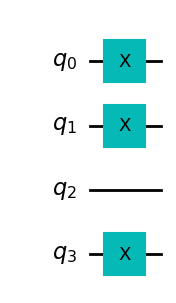

In [11]:
def shift_s(n, s):
    """주어진 s에 대해 shifting operation을 가합니다"""
    shift_s = QuantumCircuit(n)
    s = s[::-1]    # Qiskit ordering에 맞춰 bitstring 순서를 뒤집습니다
    for i in range(n):
        if s[i] == '0': 
            continue
        else:
            shift_s.x(i)    # 입력 레지스터에 X gate를 가해 shifting을 줍니다
    shift_s.name = 'Shift'
    return shift_s

# 회로를 표시합니다
shift_s(n, s).draw('mpl')

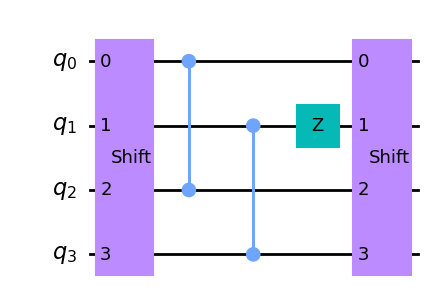

In [12]:
def oracle_g(n):
    """g = U_g를 인코딩하는 오라클입니다"""
    oracle_g = QuantumCircuit(n)
    
    # 입력값에 shifting을 줍니다
    oracle_g.append(shift_s(n, s), range(n))
    
    # Oracle U_f = (-1)^f(x) = F(x) 를 실행합니다
    # x·y는 controlled-Z gate에 해당합니다
    for i in range(int(n/2)):
        oracle_g.cz(i, i+int(n/2))
    
    # h(x) = x·e_2 는 첫 번째 레지스터의 두 번째 큐빗 = q1 에 Z gate를 가하는 것에 해당합니다
    oracle_g.z(1)
    
    # Shifting을 다시 돌려놓습니다
    oracle_g.append(shift_s(n, s), range(n))
    
    oracle_g.name = 'Oracle g'
    return oracle_g

# 회로를 표시합니다
oracle_g(n).draw('mpl')

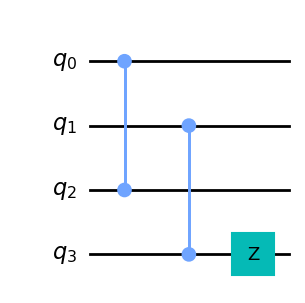

In [13]:
def oracle_f_tilde(n):
    """Fourier transform된 f = U_f tilde 를 인코딩하는 oracle입니다"""
    oracle_f_tilde = QuantumCircuit(n)
    
    # Oracle U_f tilde 를 실행합니다
    # x·y는 controlled-Z gate에 해당합니다
    for i in range(int(n/2)):
        oracle_f_tilde.cz(i, i+int(n/2))
    
    # h(y) = y·e_2 는 두 번째 레지스터의 두 번째 큐빗 = q3 에 Z gate를 가하는 것에 해당합니다
    oracle_f_tilde.z(3)
    
    oracle_f_tilde.name = 'Oracle f tilde'
    return oracle_f_tilde

# 회로를 표시합니다
oracle_f_tilde(n).draw('mpl')

여기까지 각각의 oracle을 구현했습니다. 이제 이것들을 모아서 실제 알고리즘을 회로로 구현해봅시다.

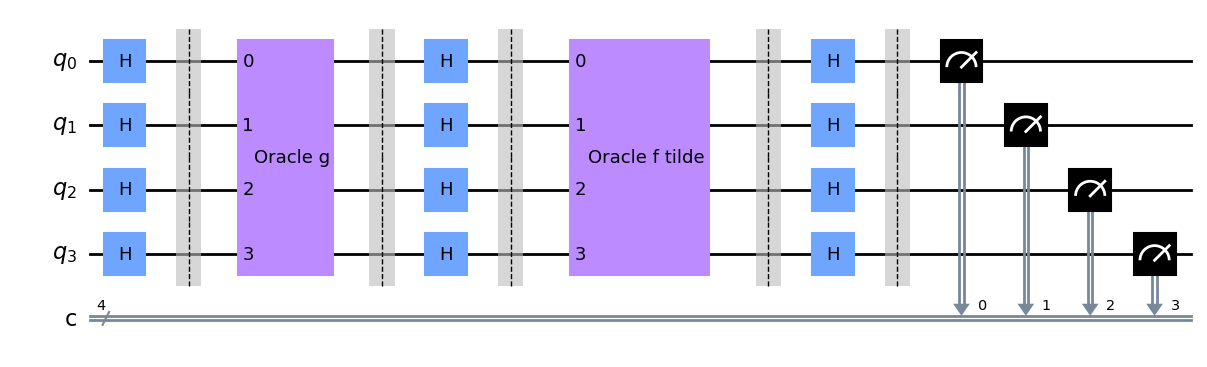

In [14]:
hsp_circuit = QuantumCircuit(n, n)

# Hadamard gate를 가해 중첩상태를 만듭니다
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()    # barrier는 시각적 분리만을 위한 것이며 실제 계산에 영향을 주지는 않습니다

# Oracle g 회로를 추가합니다
hsp_circuit.append(oracle_g(n), range(n))
hsp_circuit.barrier()

# Hadamard gate를 가해 Boolean Fourier transform을 수행합니다
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Oracle f tilde 회로를 추가합니다
hsp_circuit.append(oracle_f_tilde(n), range(n))
hsp_circuit.barrier()

# Boolean Fourier transform을 다시 수행해 s를 얻습니다
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# 큐빗을 관측합니다
for i in range(n):
    hsp_circuit.measure(i, i)

# 회로를 표시합니다
hsp_circuit.draw('mpl')

#### 3.1a Simulator로 실행하기 <a id='ftaa-simulation'> </a>

위의 회로를 simulator로 실행해봅시다.

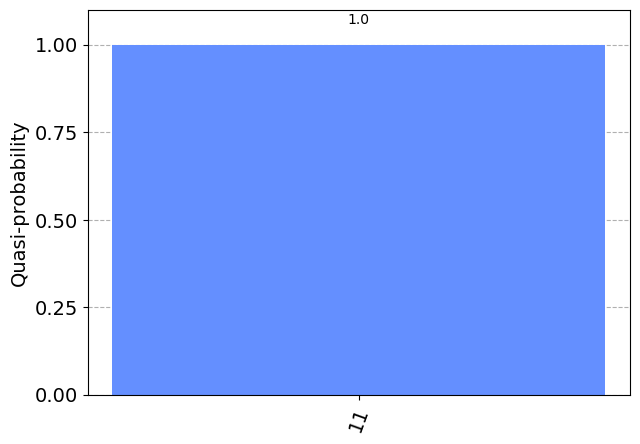

In [15]:
from qiskit.primitives import Sampler

# 로컬 (내 컴퓨터) 에서 계산을 수행합니다
sampler = Sampler()
results = sampler.run(hsp_circuit).result()
quasi_dists = results.quasi_dists

plot_histogram(quasi_dists)

측정 결과 hidden shift `1011`이 잘 출력되는 것을 확인할 수 있습니다.

#### 3.1b Real Device로 실행하기 <a id='ftaa-device'> </a>

이 회로를 실제 양자컴퓨터에서 실행해봅시다.

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler

# 저장된 IBMQ account를 불러오고 조건에 맞는 양자컴퓨터 중 가장 대기시간이 적은 백엔드를 가져옵니다.
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(filters=lambda x:
                               int(x.configuration().n_qubits) <= 4*n
                               and int(x.configuration().n_qubits) >= n
                               and not x.configuration().simulator
                               and x.status().operational==True)
print("least busy backend: ", backend)

least busy backend:  <IBMBackend('ibm_lagos')>


In [ ]:
# 불러온 백엔드에서 회로를 실행합니다
shots = 1024
options = Options(resilience_level = 1)
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(hsp_circuit, shots=shots)
    results = job.result()
    quasi_dists = results.quasi_dists

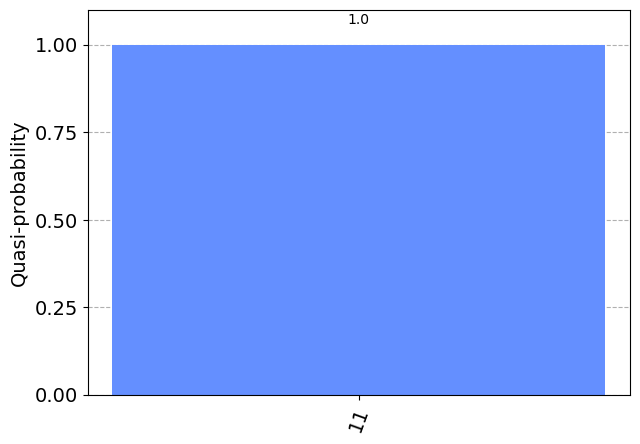

In [10]:
# 실험 결과를 표시합니다
plot_histogram(quasi_dists)

원하는 hidden shift `1011`을 얻을 확률이 가장 높은 것을 확인할 수 있습니다. 다른 결괏값들은 양자컴퓨터의 오류에 의한 값들입니다.

### 3.2 Fourier-Transform을 이용하지 않는 알고리즘 <a id='ftfa'> </a>

이번에는 더 일반적으로 적용될 수 있는 Fourier transform을 이용하지 않는 알고리즘을 살펴보도록 하겠습니다. $n$, $s$, $f$는 앞에서 사용한 것과 똑같이 설정합니다.

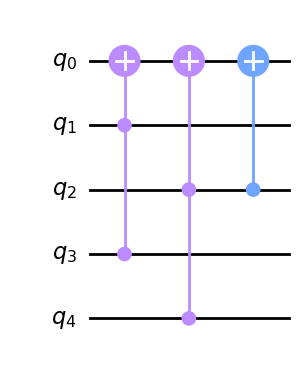

In [17]:
def oracle_f(n):
    """Oracle f"""
    oracle_f = QuantumCircuit(n+1)
    
    # f(x)를 구현합니다
    # 앞에서 controlled-Z gate를 Toffoli gate로 바꿉니다. 출력값은 첫 번째 레지스터에 출력됩니다
    for i in range(int(n/2)):
        oracle_f.ccx(i+1, i+int(n/2)+1, 0)
    
    # h(x)는 q2에서 q0로 controlled-X gate를 가하는 것이 됩니다
    oracle_f.cx(2, 0)
    
    oracle_f.name = 'Oracle f'
    return oracle_f

def oracle_g(n, s):
    """Oracle g"""
    oracle_g = QuantumCircuit(n+1)
    oracle_g.append(shift_s(n, s), qargs=[i+1 for i in range(n)])    # 입력값을 shift합니다
    oracle_g.append(oracle_f(n), range(n+1))                         # oracle f를 실행합니다
    oracle_g.append(shift_s(n, s), qargs=[i+1 for i in range(n)])    # shift를 되돌립니다
    oracle_g.name = 'Oracle g'
    return oracle_g

# Oracle f 회로를 표시합니다
oracle_f(n).draw('mpl')

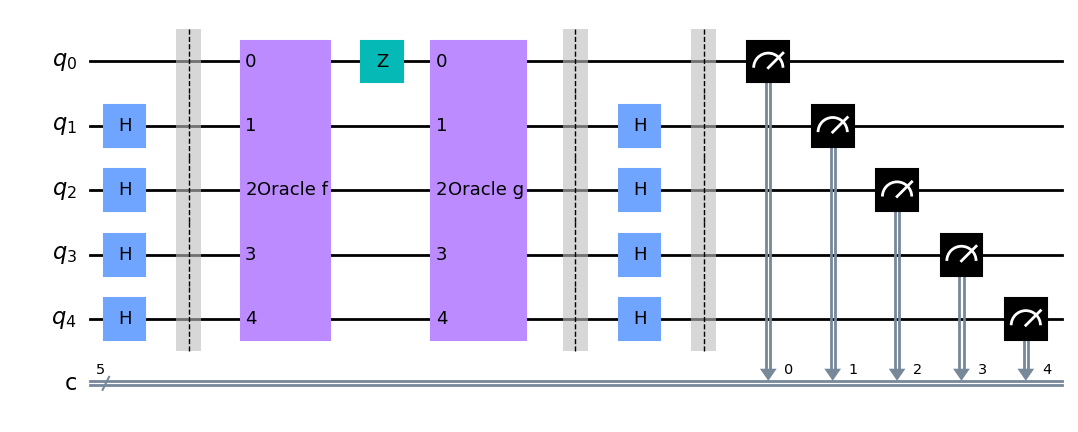

In [18]:
# Fourier-transform을 이용하지 않는 알고리즘을 만듭니다
hsp_circuit = QuantumCircuit(n+1, n+1)

# Hadamarad gate를 가해 중첩상태를 만듭니다
for i in range(n):
    hsp_circuit.h(i+1)
hsp_circuit.barrier()    # barrier는 시각적 분리만을 위한 것이며 실제 계산에 영향을 주지는 않습니다

# Oracle f, Z gate, oracle g를 순서대로 가합니다
hsp_circuit.append(oracle_f(n), range(n+1))
hsp_circuit.z(0)
hsp_circuit.append(oracle_g(n, s), range(n+1))
hsp_circuit.barrier()

# Hadamard transform을 적용합니다
for i in range(n):
    hsp_circuit.h(i+1)
hsp_circuit.barrier()

# 모든 큐빗을 관측합니다
for i in range(n+1):
    hsp_circuit.measure(i, i)

# 회로를 표시합니다
hsp_circuit.draw('mpl')

#### 3.2a Simulator로 실행하기 <a id='ftfa-simulation'> </a>

만든 회로를 simulator로 실행해봅시다

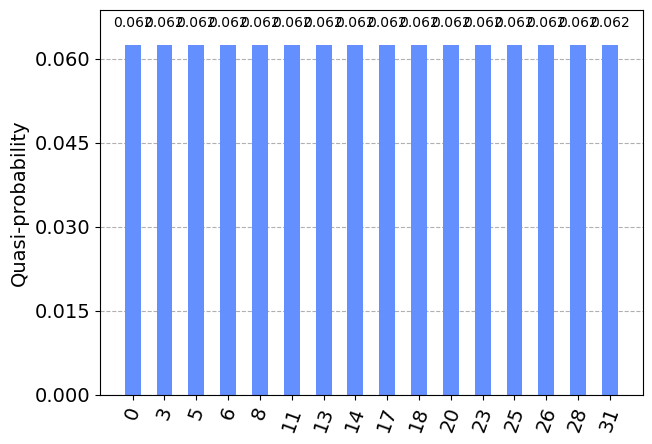

In [19]:
from qiskit.primitives import Sampler

# 로컬 (내 컴퓨터) 에서 계산을 수행합니다
sampler = Sampler()
results = sampler.run(hsp_circuit).result()
quasi_dists = results.quasi_dists

plot_histogram(quasi_dists)

결과를 확인하면 16개의 서로 다른 결괏값이 나오는 것을 확인할 수 있습니다. Binary index $b$가 첫 번째 레지스터에 있으므로 $(y, b)$ 순서로 정렬되어 있다는 점에 주의하십시오. 만약 `00000`을 제외한 4개의 linearly independent한 결괏값들을 얻게 되면 $s$를 알 수 있습니다. 예를 들어, 결괏값 `00011`, `01011`, `10100`, `11111`을 얻는 경우 $s$를 아래와 같이 얻을 수 있습니다:

$$
\begin{cases}
    \left<s \mid 0001 \right> = 1 = s_4 \\
    \left<s \mid 0101 \right> = 1 = s_2 + s_4 \\
    \left<s \mid 1010 \right> = 0 = s_1 + s_3 \\
    \left<s \mid 1111 \right> = 1 = s_1 + s_2 + s_3 + s_4
\end{cases}
\quad \therefore \left| s \right> = \left| s_1 s_2 s_3 s_4 \right> = \left| 1011 \right>
$$

따라서 hidden shift `1011`을 주어진 4개의 결괏값으로부터 얻을 수 있습니다. 모든 결괏값의 dot product $(s, 1) \cdot (y, b)$는 아래 리스트와 같습니다:

<table>
<thead>
<tr>
<th>$(s, 1)$</th>
<th>$(y, b)$</th>
<th>product</th>
<th>$(s, 1)$</th>
<th>$(y, b)$</th>
<th>product</th>
</tr>
</thead>
<tbody>
<tr>
<th>10111</th>
<th>00000</th>
<th>0</th>
<th>10111</th>
<th>10001</th>
<th>1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>00011</th>
<th>1+1=0</th>
<th>10111</th>
<th>10010</th>
<th>1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>00101</th>
<th>1+1=0</th>
<th>10111</th>
<th>10100</th>
<th>1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>00110</th>
<th>1+1=0</th>
<th>10111</th>
<th>10111</th>
<th>1+1+1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>01000</th>
<th>0</th>
<th>10111</th>
<th>11001</th>
<th>1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>01011</th>
<th>1+1=0</th>
<th>10111</th>
<th>11010</th>
<th>1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>01101</th>
<th>1+1=0</th>
<th>10111</th>
<th>11100</th>
<th>1+1=0</th>
</tr>
<tr>
<th>10111</th>
<th>01110</th>
<th>1+1=0</th>
<th>10111</th>
<th>11111</th>
<th>1+1+1+1=0</th>
</tr>
</tbody>
</table>

#### 3.2b Real Device로 실행하기 <a id='ftfa-device'> </a>

이번에는 실제 양자컴퓨터로 실행해봅시다.

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler

# 조건에 맞는 양자컴퓨터 중 가장 대기시간이 적은 백엔드를 가져옵니다
backend = service.least_busy(filters=lambda x:
                               int(x.configuration().n_qubits) <= 4*(n+1)
                               and int(x.configuration().n_qubits) >= n+1
                               and not x.configuration().simulator
                               and x.status().operational==True)
print("least busy backend: ", backend)

least busy backend:  <IBMBackend('ibm_lagos')>


In [ ]:
# 불러온 백엔드에서 회로를 실행합니다
shots = 1024
options = Options(resilience_level = 1)
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(hsp_circuit, shots=shots)
    results = job.result()
    quasi_dists = results.quasi_dists

In [ ]:
# 실험 결과를 표시합니다
plot_histogram(quasi_dists)

그러나 이 경우, 우리가 원하는 결과를 노이즈와 구분할 수 없는 것을 확인할 수 있습니다. 한 가지 이유는 현재의 컴퓨터에서는 Toffoli gate가 코스트가 높기 때문이고, 또 하나는 우리가 원하는 결괏값이 1/16 정도 확률밖에 안 된다는 점도 있을 것입니다. 이러한 노이즈를 정정하거나 완화하는 것도 연구자들에게는 중요한 이슈입니다.

## 4. 문제 <a id='problems'> </a>

아래의 함수 `hsp_oracle`는 integer `seed`, Booleans `output`, `shifted`, `fourier_transformed`을 입력으로 받습니다. 이 함수는 4-큐빗을 입력으로 받는 oracle 회로를 돌려줄 것입니다. 양자 알고리즘을 이용해 hidden shift $s$를 찾아보세요.

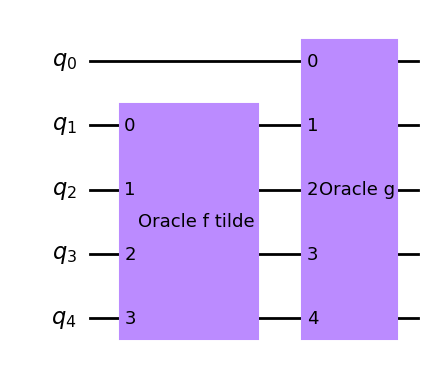

In [22]:
from problems import hsp_oracle
# 사용법 예시
n = 4
seed = 137
oracle_f_tilde = hsp_oracle(seed, output=False, shifted=False, fourier_transformed=True)
oracle_g = hsp_oracle(seed, output=True, shifted=True, fourier_transformed=False)
qc = QuantumCircuit(n+1)
qc.append(oracle_f_tilde, [i+1 for i in range(n)])
qc.append(oracle_g, range(n+1))
qc.draw('mpl')

1. 주어진 hidden shift problem을 Fourier transform $\tilde{f}$를 이용해 풀어보세요.

In [ ]:
hsp_circuit = QuantumCircuit(n)

####################
# Your codes Here

####################

# Display circuit
hsp_circuit.draw('mpl')

In [ ]:
# Check the result
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

2. 주어진 hidden shift problem을 Fourier transform $\tilde{f}$를 이용하지 않고 풀어보세요.

In [ ]:
hsp_circuit = QuantumCircuit(n+1)

####################
# 여기에 코드를 작성해주세요

####################

# 회로를 표시합니다
hsp_circuit.draw('mpl')

In [ ]:
# 결과를 확인합니다
sampler = Sampler()
results = sampler.run(hsp_circuit).result()
quasi_dists = results.quasi_dists

plot_histogram(quasi_dists)

## 5. 참고자료 <a id='references'> </a>

1. M. Roetteler (2008), "Quantum algorithms for highly non-linear Boolean functions", Proceedings of the 21st Annual ACM-SIAM Symposium on Discrete Algorithms (SODA'10), pp. 448-457, [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) [quant-ph]
2. D. Gavinsky, M. Roetteler & J. Roland (2011), "Quantum Algorithm for the Boolean Hidden Shift Problem", 17th International Computing & Combinatorics Conference (COCOON'11), Lecture Notes in Computer Science 6842 (Springer), pp. 158-167, [doi:10.1007/978-3-642-22685-4_14](https://doi.org/10.1007/978-3-642-22685-4_14), [arXiv:1103.3017](https://arxiv.org/abs/1103.3017) [quant-ph]
3. N. Tokareva (2015), "Bent Functions - Results and Applications to Cryptography", Academic Press. 
4. X. Bonnetain & M. Naya-Plasencia (2018), "Hidden Shift Quantum Cryptanalysis and Implications", In: T. Peyrin , S. Galbraith (eds) Advances in Cryptology – ASIACRYPT 2018, Lecture Notes in Computer Science, vol 11272, Springer, Cham, [doi:10.1007/978-3-030-03326-2_19](https://doi.org/10.1007/978-3-030-03326-2_19)
5. K. Wright, K. M. Beck, S. Debnath et al. (2019), "Benchmarking an 11-qubit quantum computer", Nat Commun 10, 5464, [doi:10.1038/s41467-019-13534-2](https://doi.org/10.1038/s41467-019-13534-2)
6. S. Bravyi & D. Gosset (2016), "Improved classical simulation of quantum circuits dominated by Clifford gates", Phys. Rev. Lett. 116, 250501, [doi:10.1103/PhysRevLett.116.250501](https://doi.org/10.1103/PhysRevLett.116.250501), [arXiv:1601.07601](https://arxiv.org/abs/1601.07601) [quant-ph]
<!-- 6. G. Kuperberg (2005), "A subexponential-time quantum algorithm for the dihedral hidden subgroup problem", SIAM Journal on Computing, 35(1), pp. 170-188, [doi:10.1137/S0097539703436345](https://doi.org/10.1137/S0097539703436345), [arXiv:quant-ph/0302112](https://arxiv.org/abs/quant-ph/0302112) -->

In [23]:
import qiskit.tools.jupyter
%qiskit_version_table